<a href="https://colab.research.google.com/github/MichelleAppel/distribution-aware-image-to-image-translation/blob/master/experiments_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

from sklearn.decomposition import PCA

import numpy as np
import math
import itertools

from scipy import signal

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
# Becasue MNIST server is down
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Toy example MNIST with PCA embeddings (one-sided)

## Dataset

In [ ]:
def n_centered_moment(x, w, n):
  if n > 1:
    c = n_centered_moment(x, w, 1)
  else:
    c = 0
  return (((x - c)**n)*w).sum(0)

In [ ]:
def relative_distribution(label):
  label_counts = label.unique(return_counts=True)[1]
  return label_counts.float() / label_counts.sum()

In [48]:
def MNIST_data_dist(distribution=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], one_hot_labels=False):
    # distribution: distribution for each label
    # returns (data, labels) for MNIST with all the classes; zeroes and ones have the given distribution

    MNIST = torchvision.datasets.MNIST('/content/drive/MyDrive/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
    
    distribution /= np.array(distribution).sum()
    
    # bool mask for each label
    idxm = [MNIST.targets==label for label in range(len(distribution))]
    min_idx = torch.Tensor([sum(i) for i in idxm]).min().int().item()
    tot_idx = torch.Tensor([sum(i) for i in idxm]).sum().int().item()

    # list of indices for each label
    idx = [np.where(idxm[label])[0] for label in range(len(distribution))]
    


    len_idx = torch.Tensor([len(i) for i in idx])
    wanted_len = torch.Tensor([d*tot_idx for d in distribution])

    min_class = ((len_idx/wanted_len).argmin())
    min = ((len_idx/wanted_len).min().item())

    if min < 1:
      distribution *= min

    valid_idx = []
    class_len = [math.floor(d*tot_idx) for d in distribution]
    for label, length in enumerate(class_len):
      valid_idx += idx[label][:length].tolist()

    valid_idx = np.array(valid_idx)
    np.random.shuffle(valid_idx)

    # assign the new data and labels to the dataset
    if one_hot_labels:
      MNIST.targets = torch.nn.functional.one_hot(MNIST.targets[valid_idx])
    else:
      MNIST.targets = MNIST.targets[valid_idx]
    MNIST.data = MNIST.data[valid_idx]

    return MNIST 

In [49]:
def MNIST_data(one_hot_labels=False):
    # distribution: distribution for each label
    # returns (data, labels) for MNIST with all the classes; zeroes and ones have the given distribution

    MNIST = torchvision.datasets.MNIST('/content/drive/MyDrive/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
    
    
    if one_hot_labels:
      MNIST.targets = torch.nn.functional.one_hot(MNIST.targets)
    else:
      MNIST.targets = MNIST.targets
    MNIST.data = MNIST.data

    return MNIST 

In [50]:
class MNISTDataset(Dataset):
    '''The dataset for the MNIST binary data
    '''
    def __init__(self, n_classes=10, one_hot_labels=False):

        # self.distribution = distribution        
        self.dataset = MNIST_data(one_hot_labels=one_hot_labels)
        # to take out in real applications
        self.unique_labels = torch.unique(self.dataset.targets)[:n_classes]
        
        self.example_imgs = self.example(n_classes)

    def example(self, n_classes, n_per_class=50):
        '''
        Returns an example from each digit in the domain
        
        '''
        self.n_per_class = n_per_class
        labels = self.dataset.targets
        data = self.dataset.data

        img = []
        for label in self.unique_labels:
          img = img + [data[labels==label][:n_per_class]]

        ex = torch.cat(img, 0).unsqueeze(1)
              
        return ex

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

In [51]:
class DistBatchSampler(torch.utils.data.Sampler):
    def __init__(self, dataset, distribution, batch_size, n_batches=10000, shuffle=True):
        self.dataset = dataset
        self.targets = dataset.dataset.targets

        distribution /= np.array(distribution).sum()
        self.distribution = distribution
        self.batch_size = batch_size
        self.n_batches = n_batches
        self.shuffle = shuffle

        idxm = [self.targets==label for label in range(len(distribution))]
        min_idx = torch.Tensor([sum(i) for i in idxm]).min().int().item()
        tot_idx = batch_size#torch.Tensor([sum(i) for i in idxm]).sum().int().item()

        # list of indices for each label
        self.idx = [np.where(idxm[label])[0] for label in range(len(distribution))]

        len_idx = torch.Tensor([len(i) for i in self.idx])
        self.wanted_len = torch.Tensor([d*tot_idx for d in distribution])

        self.class_idx = [(self.targets==c).nonzero().squeeze() for c in range(len(self.distribution))]

    def __iter__(self):
        valid_idxs = []
        for b in range(self.n_batches):
          valid_idx = ()

          for label, length in enumerate(self.wanted_len):
            if self.shuffle:
              class_idx = self.class_idx[label][torch.randperm(len(self.class_idx[label]))]
            else:
              class_idx = self.class_idx[label]

            valid_idx += (class_idx[:int(length)], )
          valid_idxs += [torch.cat(valid_idx).tolist()]

        return iter(valid_idxs) 
    
    def __len__(self):
        return self.batch_size

## Networks

In [52]:
class WeightNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(WeightNet, self).__init__()
        self.softmax = nn.Softmax(dim=0)

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 40)
        self.fc2 = nn.Linear(40, 1)
        
    def forward(self, x):
        h1 = torch.sigmoid(F.max_pool2d(self.conv1(x), 2))
        h2 = torch.sigmoid(F.max_pool2d(self.conv2(h1), 2))
        h3 = h2.view(-1, 320)
        h4 = torch.sigmoid(self.fc1(h3))
        out = self.fc2(h4)
        return self.softmax(out), out

In [53]:
def raw_to_onehot(labels, n_classes):
  onehot = torch.zeros(len(labels), n_classes)
  for c in labels.unique():
    onehot[labels==c, c] = 1
  return onehot

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=128):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=128, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            # nn.Conv2d(128, 256, kernel_size=4, stride=2),
            # nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, image_channels, kernel_size=4, stride=2),
            # nn.ReLU(),
            # nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.fc3(z)
        return self.decoder(z), mu, logvar

In [55]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    return BCE + KLD

## Train VAE

In [ ]:
# Initialize the networks
# weight_network = WeightNet().cuda()
autoencoder = VAE().cuda()

# Initialize the optimizers
lr = 0.01
# optimizer_w = optim.Adam(weight_network.parameters(), lr=lr)
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=lr)

# criterion_w = nn.MSELoss()
criterion_ae = nn.BCELoss()

# For storing results
# losses_w = []
losses_ae = []

means_A = []
means_B = []

vars_A = []
vars_B = []

moments_A = []
moments_B = []

example_importances_A = []

n = 2 # n-centered moment
n_classes = len(dataset_A.distribution)

for epoch in range(10):
    for i, real_B in enumerate(dataloader_B):
        
        img_B = real_B[0].cuda()

        reconstructed_B, mu, logvar = autoencoder(img_B)


        loss_ae = loss_fn(reconstructed_B, img_B, mu, logvar)
        # loss_ae_B = criterion_ae(reconstructed_B, img_B)
        # loss_ae = loss_ae_B
        # ---------------------------------------------------------------------------------------------------

        optimizer_ae.zero_grad()
        loss_ae.backward()
        optimizer_ae.step()     

        # Store values --------------------------------------------------------------------------------------

        losses_ae += [loss_ae.item()]

        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 50 == 0:
            print('epoch', epoch, 'step', i, 'loss_ae', loss_ae.item())
            
        if i % 10000 == 0 and i != 0:
            break

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch 0 step 0 loss_ae 129868.2421875
epoch 0 step 50 loss_ae -3160819.75
epoch 0 step 100 loss_ae -4003730.25
epoch 0 step 150 loss_ae -6978017.5
epoch 0 step 200 loss_ae -7945043.0
epoch 1 step 0 loss_ae -8059018.0
epoch 1 step 50 loss_ae -8427438.0
epoch 1 step 100 loss_ae -8704432.0
epoch 1 step 150 loss_ae -8823524.0
epoch 1 step 200 loss_ae -8848924.0
epoch 2 step 0 loss_ae -9094753.0
epoch 2 step 50 loss_ae -9042055.0
epoch 2 step 100 loss_ae -9228278.0
epoch 2 step 150 loss_ae -9236215.0
epoch 2 step 200 loss_ae -9193350.0
epoch 3 step 0 loss_ae -9305410.0
epoch 3 step 50 loss_ae -9245121.0
epoch 3 step 100 loss_ae -9184088.0
epoch 3 step 150 loss_ae -9346830.0
epoch 3 step 200 loss_ae -9292300.0
epoch 4 step 0 loss_ae -9376645.0
epoch 4 step 50 loss_ae -9297124.0
epoch 4 step 100 loss_ae -9391111.0
epoch 4 step 150 loss_ae -9489340.0
epoch 4 step 200 loss_ae -9305339.0
epoch 5 step 0 loss_ae -9448864.0
epoch 5 step 50 loss_ae -9433456.0
epoch 5 step 100 loss_ae -9341398.0
epoc

NameError: ignored

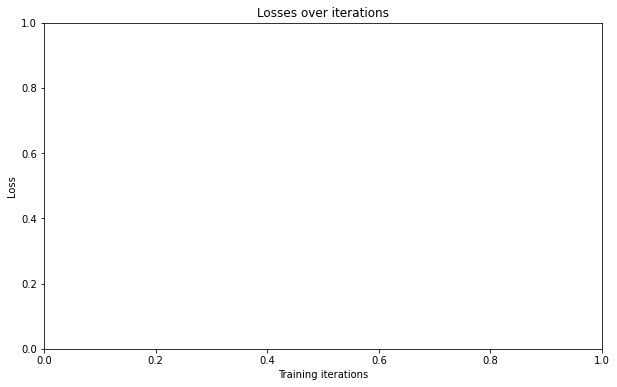

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
# plt.yscale('symlog')
smoothed_losses_ae = signal.savgol_filter(losses_ae,101,3)
plt.plot(smoothed_losses_ae)
plt.legend(['AE'])
plt.show()

## Save/load VAE

In [56]:
# torch.save(autoencoder.state_dict(), '/content/drive/MyDrive/VAE.pth')

In [57]:
autoencoder = VAE().cuda()
autoencoder.load_state_dict(torch.load('/content/drive/MyDrive/VAE.pth'))
autoencoder.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Flatten()
  )
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=128, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

## Train Weightnetwork

In [307]:
batch_size = 100

# Settings for domain A
# dist_A = [0.2, 0.8]
dist_A = [0.1, 0.5, 0.3]
# dist_A = [0.2, 0.3, 0.25, 0.25]
# dist_A = [0.05, 0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

# Settings for domain B
# dist_B = [0.5, 0.5]
dist_B = [0.3, 0.3, 0.3]
# dist_B = [0.25, 0.25, 0.25, 0.25]
# dist_B = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

dataset_A = MNISTDataset(n_classes=len(dist_A))
dataset_B = MNISTDataset(n_classes=len(dist_B))

In [308]:
# Exact occurences in batch

dataloader_A = DataLoader(dataset_A, batch_sampler=DistBatchSampler(dataset=dataset_A, distribution=dist_A, batch_size=batch_size))
dataloader_B = DataLoader(dataset_B, batch_sampler=DistBatchSampler(dataset=dataset_B, distribution=dist_B, batch_size=batch_size))

In [309]:
# # Sample batch from distribution

# counts_A = dataset_A.dataset.targets.unique(return_counts=True)[1]
# init_dist_A = counts_A/sum(counts_A)
# compensated_dist_A = torch.Tensor(dist_A)/init_dist_A

# weights_A = torch.zeros(len(dataset_A.dataset.targets))
# for c, w in enumerate(compensated_dist_A):
#   weights_A[dataset_A.dataset.targets==c] = w
# sampler = torch.utils.data.WeightedRandomSampler(weights_A, batch_size, replacement=True, generator=None)
# batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last=True)

# dataloader_A = DataLoader(dataset_A, batch_sampler=batch_sampler)


# counts_B = dataset_B.dataset.targets.unique(return_counts=True)[1]
# init_dist_B = counts_B/sum(counts_B)
# compensated_dist_B = torch.Tensor(dist_B)/init_dist_B

# weights_B = torch.zeros(len(dataset_B.dataset.targets))
# for c, w in enumerate(dist_B):
#   weights_B[dataset_B.dataset.targets==c] = w
# sampler = torch.utils.data.WeightedRandomSampler(weights_B, batch_size, replacement=True, generator=None)
# batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last=True)

# dataloader_B = DataLoader(dataset_B, batch_sampler=batch_sampler)

In [310]:
# Initialize the networks
weight_network = WeightNet().cuda()

# Initialize the optimizers
lr = 0.00005
optimizer_w = optim.Adam(weight_network.parameters(), lr=lr)

# criterion_w = nn.KLDivLoss(reduction='sum')
criterion_w = nn.MSELoss()

# For storing results
losses_w = []

means_A = []
means_B = []

vars_A = []
vars_B = []

moments_A = []
moments_B = []

example_importances_A = []

n = 1 # n-centered moment
n_classes = len(dist_A)

for epoch in range(1):
    for i, (real_A, real_B) in enumerate(zip(dataloader_A, dataloader_B)):
        
        img_A = real_A[0].cuda()
        img_B = real_B[0].cuda()

        label_A = raw_to_onehot(real_A[1], n_classes).cuda()
        label_B = raw_to_onehot(real_B[1], n_classes).cuda()

        # The embeddings
        reconstructed_A, mu_A, logvar_A = autoencoder(img_A)
        reconstructed_B, mu_B, logvar_B = autoencoder(img_B)

        # The weighting process
        w_A = weight_network(img_A)[0]
        w_B = 1/len(img_B)

        # The loss function --------------------------------------------------------------------------------

        z_A = autoencoder.reparameterize(mu_A, logvar_A)
        z_B = autoencoder.reparameterize(mu_B, logvar_B)

        n_centered_moment_A = n_centered_moment(z_A.detach(), w_A, n)
        n_centered_moment_B = n_centered_moment(z_B.detach(), w_B, n)


        # n_centered_moment_A = n_centered_moment(label_A.detach(), w_A, n)
        # n_centered_moment_B = n_centered_moment(label_B.detach(), w_B, n)

        # n_centered_moment_A = -0.5 * torch.sum((1 + logvar_A.detach() - mu_A.detach()**2 - logvar_A.exp().detach())*w_A)
        # n_centered_moment_B = -0.5 * torch.sum((1 + logvar_B.detach() - mu_B.detach()**2 - logvar_B.exp().detach())*w_B)

        loss_w = criterion_w(n_centered_moment_A, n_centered_moment_B)

        # ---------------------------------------------------------------------------------------------------

        # Backward
        optimizer_w.zero_grad()
        loss_w.backward()
        optimizer_w.step() 

        # Store values --------------------------------------------------------------------------------------
        moments_A += [n_centered_moment_A.cpu().detach().numpy()]
        moments_B += [n_centered_moment_B.cpu().detach().numpy()]

        means_A += [n_centered_moment(label_A, w_A, 1).detach().cpu().numpy()]
        means_B += [n_centered_moment(label_B, w_B, 1).detach().cpu().numpy()]

        vars_A += [n_centered_moment(label_A, w_A, 2).detach().cpu().numpy()]
        vars_B += [n_centered_moment(label_B, w_B, 2).detach().cpu().numpy()]    

        losses_w += [loss_w.item()]

        w_a = weight_network(dataset_A.example_imgs.cuda().float())
        example_importances_A += [[importance.item() for importance in w_a[0]]] # Store examples in a list

        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 50 == 0:
            print('epoch', epoch, 'step', i, 'loss_w: ', loss_w.item())#, 'distribution A', relative_distribution(real_A[1]), real_A[1].unique(return_counts=True)[1], 'distribution B', relative_distribution(real_B[1]), real_B[1].unique(return_counts=True)[1])
            
        if i % 10000 == 0 and i != 0:
            break

epoch 0 step 0 loss_w:  0.06353825330734253
epoch 0 step 50 loss_w:  0.07623418420553207
epoch 0 step 100 loss_w:  0.06842102110385895
epoch 0 step 150 loss_w:  0.07559281587600708
epoch 0 step 200 loss_w:  0.060416318476200104
epoch 0 step 250 loss_w:  0.03914004564285278
epoch 0 step 300 loss_w:  0.03657439351081848
epoch 0 step 350 loss_w:  0.020763669162988663
epoch 0 step 400 loss_w:  0.01349390298128128
epoch 0 step 450 loss_w:  0.017618820071220398
epoch 0 step 500 loss_w:  0.01823587715625763
epoch 0 step 550 loss_w:  0.014625562354922295
epoch 0 step 600 loss_w:  0.02265666425228119
epoch 0 step 650 loss_w:  0.007966811768710613
epoch 0 step 700 loss_w:  0.013330494984984398
epoch 0 step 750 loss_w:  0.012475838884711266
epoch 0 step 800 loss_w:  0.02823379635810852
epoch 0 step 850 loss_w:  0.012966100126504898
epoch 0 step 900 loss_w:  0.022757312282919884
epoch 0 step 950 loss_w:  0.011943716555833817
epoch 0 step 1000 loss_w:  0.017342180013656616
epoch 0 step 1050 loss_w:

KeyboardInterrupt: ignored

In [311]:
moments_A = torch.Tensor(moments_A)
moments_B = torch.Tensor(moments_B)
means_A = torch.Tensor(means_A)
means_B = torch.Tensor(means_B)
vars_A = torch.Tensor(vars_A)
vars_B = torch.Tensor(vars_B)

## Results

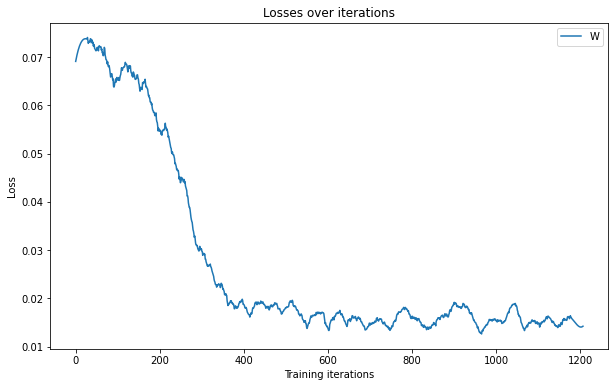

In [312]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
# plt.yscale('symlog')
smoothed_losses_w = signal.savgol_filter(losses_w,55,3)
plt.plot(smoothed_losses_w)
plt.legend(['W'])
plt.show()

The plot below shows that the classes 0 and 1 in domain A are weighted to match the uniform distribution in domain B.

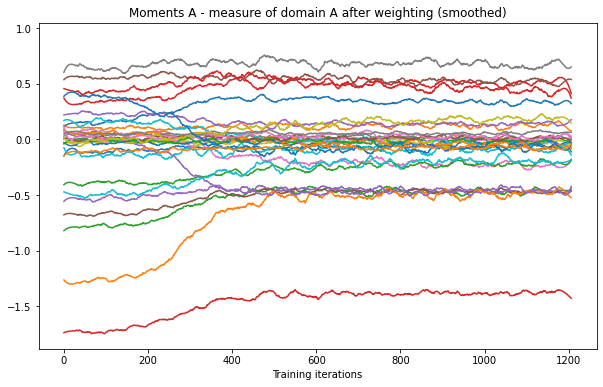

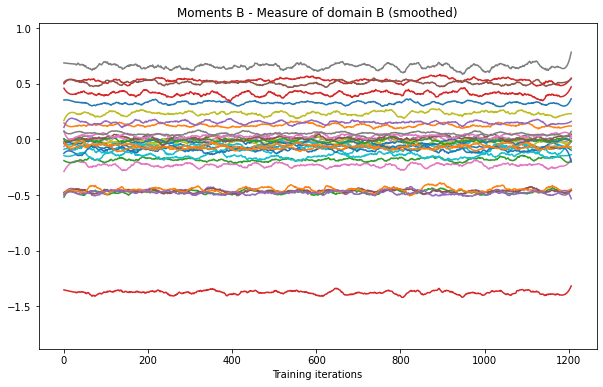

In [313]:
plt.figure(figsize=(10,6))
plt.title('Moments A - measure of domain A after weighting (smoothed)')
plt.xlabel('Training iterations')
# plt.ylabel('Loss')
plt.ylim(ymax = moments_A.max(), ymin = moments_A.min())
smoothed_Lmin = signal.savgol_filter(moments_A,55,3,axis=0)
plt.plot(smoothed_Lmin)
# plt.legend(np.arange(len(moments_A[0])))
plt.show()

plt.figure(figsize=(10,6))
plt.title('Moments B - Measure of domain B (smoothed)')
plt.xlabel('Training iterations')
# plt.ylabel('Loss')
plt.ylim(ymax = moments_A.max(), ymin = moments_A.min())
smoothed_Lplus = signal.savgol_filter(moments_B,55,3,axis=0)
plt.plot(smoothed_Lplus)
# plt.legend(np.arange(len(moments_A[0])))
plt.show()

In [277]:
# # plt.figure(figsize=(10,6))
# plt.title('Moments A - measure of domain A after weighting (smoothed)')
# plt.xlabel('Training iterations')
# plt.ylabel('Loss')
# # plt.ylim(ymax = moments_A.max(), ymin = moments_A.min())
# smoothed_Lmin = signal.savgol_filter(moments_A,101,3,axis=0)
# plt.plot(smoothed_Lmin)
# smoothed_Lplus = signal.savgol_filter(moments_B,101,3,axis=0)
# plt.plot(smoothed_Lplus)
# # plt.legend(np.arange(len(moments_A[0])))
# plt.show()

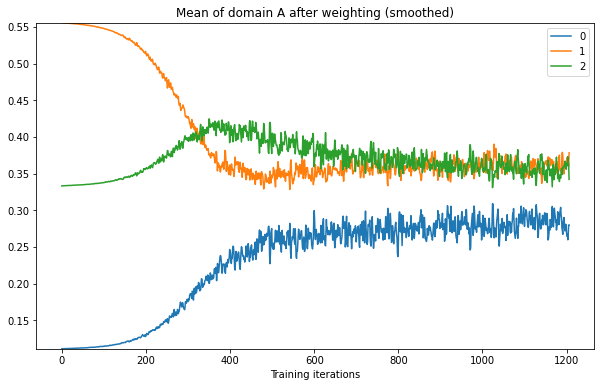

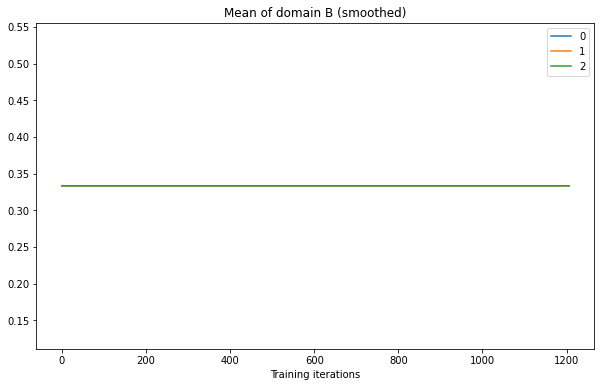

In [314]:
plt.figure(figsize=(10,6))
plt.title('Mean of domain A after weighting (smoothed)')
plt.xlabel('Training iterations')
# plt.ylabel('Loss')
plt.ylim(ymax = means_A.max(), ymin = means_A.min())
smoothed_means_A = signal.savgol_filter(means_A,5,3,axis=0)
plt.plot(smoothed_means_A)
plt.legend(np.arange(n_classes))
plt.show()

plt.figure(figsize=(10,6))
plt.title('Mean of domain B (smoothed)')
plt.xlabel('Training iterations')
# plt.ylabel('Loss')
plt.ylim(ymax = means_A.max(), ymin = means_A.min())
smoothed_means_B = signal.savgol_filter(means_B,5,3,axis=0)
plt.plot(smoothed_means_B)
plt.legend(np.arange(n_classes))
plt.show()

In [279]:
# plt.figure(figsize=(10,6))
# plt.title('Var of domain A after weighting (smoothed)')
# plt.xlabel('Training iterations')
# plt.ylabel('Loss')
# plt.ylim(ymax = vars_A.max(), ymin = vars_A.min())
# smoothed_vars_A = signal.savgol_filter(vars_A,101,3,axis=0)
# plt.plot(smoothed_vars_A)
# plt.legend(np.arange(n_classes))
# plt.show()

# plt.figure(figsize=(10,6))
# plt.title('Var of domain B (smoothed)')
# plt.xlabel('Training iterations')
# plt.ylabel('Loss')
# plt.ylim(ymax = vars_A.max(), ymin = vars_A.min())
# smoothed_vars_B = signal.savgol_filter(vars_B,101,3,axis=0)
# plt.plot(smoothed_vars_B)
# plt.legend(np.arange(n_classes))
# plt.show()

In [280]:
# plt.figure(figsize=(10,6))
# plt.title('Mean and var of domain A after weighting (smoothed)')
# plt.xlabel('Training iterations')
# plt.ylabel('Loss')
# plt.ylim(ymax = (smoothed_means_A + smoothed_vars_A).max(), ymin = (smoothed_means_A - smoothed_vars_A).min())
# plt.plot(smoothed_means_A)
# for i in range(smoothed_means_A.shape[1]):
#   plt.fill_between(np.arange(len(smoothed_means_A)), (smoothed_means_A - smoothed_vars_A)[:, i], (smoothed_means_A + smoothed_vars_A)[:, i], alpha=0.1)
# plt.legend(np.arange(n_classes))
# plt.show()

# plt.figure(figsize=(10,6))
# plt.title('Mean and var of domain A after weighting (smoothed)')
# plt.xlabel('Training iterations')
# plt.ylabel('Loss')
# plt.ylim(ymax = (smoothed_means_A + smoothed_vars_A).max(), ymin = (smoothed_means_A - smoothed_vars_A).min())
# plt.plot(smoothed_means_B)
# for i in range(smoothed_means_B.shape[1]):
#   plt.fill_between(np.arange(len(smoothed_means_B)), (smoothed_means_B - smoothed_vars_B)[:, i], (smoothed_means_B + smoothed_vars_B)[:, i], alpha=0.1)
# plt.legend(np.arange(n_classes))
# plt.show()

Here you see the weights assigned to the classes in domain A. As expected, 0 gets a large weight as it is underrepresented in domain A, and 1 gets a small weight as it is overrepresented in domain A.

In [315]:
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:pink', 'tab:cyan', 'tab:gray', 'darksalmon', 'red']

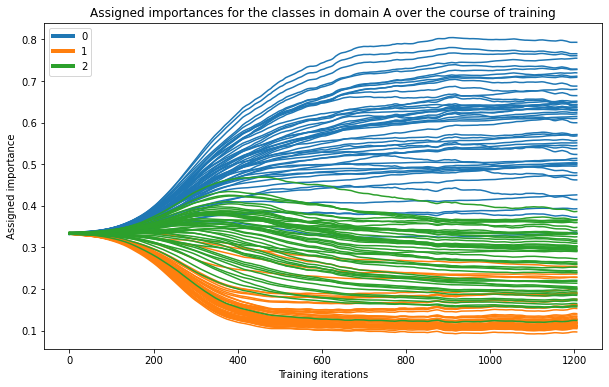

In [316]:
plt.figure(figsize=(10,6))
plt.title('Assigned importances for the classes in domain A over the course of training')
example_importances_A = example_importances_A
smoothed_importances_A = signal.savgol_filter(example_importances_A,5,3,axis=0)

smoothed_importances_A *= 50

custom_lines = []
for c in range(n_classes):
  plt.plot(smoothed_importances_A[:, 50*c:50*(c+1)], color=color_list[c])
  custom_lines += [Line2D([0], [0], color=color_list[c], lw=4)]

plt.legend(custom_lines, np.arange(n_classes))
plt.ylabel('Assigned importance')
plt.xlabel('Training iterations')
plt.show()
# print('final weights', example_importances_A[-1])

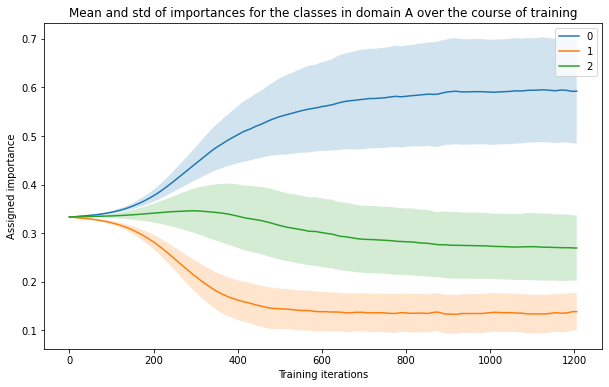

final mu [0.5920444505887895, 0.13847164185052452, 0.26948393547707866]
final std [0.10704193552673266, 0.03867451557405772, 0.06733052877674997]


In [317]:
plt.figure(figsize=(10,6))
plt.title('Mean and std of importances for the classes in domain A over the course of training')

custom_lines = []
t = np.arange(len(smoothed_importances_A))

final_mus = []
final_std = []
for c in range(n_classes):
  values = smoothed_importances_A[:, 50*c:50*(c+1)]
  mu = values.mean(1)
  sigma = values.std(1)
  plt.plot(mu, color=color_list[c])
  plt.fill_between(t, mu+sigma, mu-sigma, facecolor=color_list[c], alpha=0.20)
  custom_lines += [Line2D([0], [0], color=color_list[c], lw=4)]
  final_mus += [mu[-1]]
  final_std += [sigma[-1]]

plt.legend(np.arange(n_classes))
plt.ylabel('Assigned importance')
plt.xlabel('Training iterations')
plt.show()
print('final mu', final_mus)
print('final std', final_std)

In [318]:
w_A = torch.Tensor(final_mus)

rec_B = torch.Tensor(dist_A)*w_A
rec_B /= rec_B.sum()
print('original distribution A     ', (torch.Tensor(dist_A)/sum(dist_A)))
print('reconstructed distribution B', rec_B)
print('real distribution B         ', (torch.Tensor(dist_B)/sum(dist_B)))
print('difference                  ', (rec_B - (torch.Tensor(dist_B)/sum(dist_B))))

original distribution A      tensor([0.1111, 0.5556, 0.3333])
reconstructed distribution B tensor([0.2829, 0.3308, 0.3863])
real distribution B          tensor([0.3333, 0.3333, 0.3333])
difference                   tensor([-0.0504, -0.0025,  0.0530])


## More results

In [319]:
# dataset_MNIST = MNISTDataset(distribution=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
batch_size = 100
dataset = MNISTDataset(n_classes=len(dist_B))
dataloader = DataLoader(dataset, batch_sampler=DistBatchSampler(dataset=dataset, distribution=dist_B, batch_size=batch_size))

imgs = ()
recs = ()
mus = ()
vars = ()
ws = ()
labels = ()
n_classes = 10

for i, dataexample in enumerate(dataloader):
    img = dataexample[0].cuda()

    label = dataexample[1]
    
    # The embeddings
    reconstructed, mu, var = autoencoder(img)

    # The weighting process
    # w = weight_network(img)[0]

    imgs += (img.detach().cpu(), )
    recs += (reconstructed.detach().cpu(), )
    mus += (mu.detach().cpu(), )
    vars += (var.detach().cpu(), )
    ws += (weight_network(img)[0].detach(), )

    labels += (label, )
    # zs += (z.detach().cpu(), )
    # ws += (w.detach().cpu(), )

    if i > 11:
      break # otherwise cuda out of memory

# zs = torch.cat(zs)
# ws = torch.cat(ws)
labels = torch.cat(labels)
imgs = torch.cat(imgs)
recs = torch.cat(recs)
mus = torch.cat(mus)
vars = torch.cat(vars)
ws = torch.cat(ws)

In [320]:
from torchvision.utils import make_grid

def visualize_grid(img):
  plt.figure(figsize=(15,15))
  plt.imshow(img.permute(1,2,0))
  plt.axis('off')
  plt.show()

In [321]:
# visualize_grid(make_grid(imgs[:28], nrow=7))
# visualize_grid(make_grid(recs[:28], nrow=7))

In [322]:
sorted_ws, indices_ws = torch.sort(ws.squeeze())

In [323]:
sorted_weights = (sorted_ws*50).cpu()

In [324]:
# visualize_grid(make_grid(imgs[indices_ws], nrow=7))
# print(sorted_ws)

targets = imgs[indices_ws]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


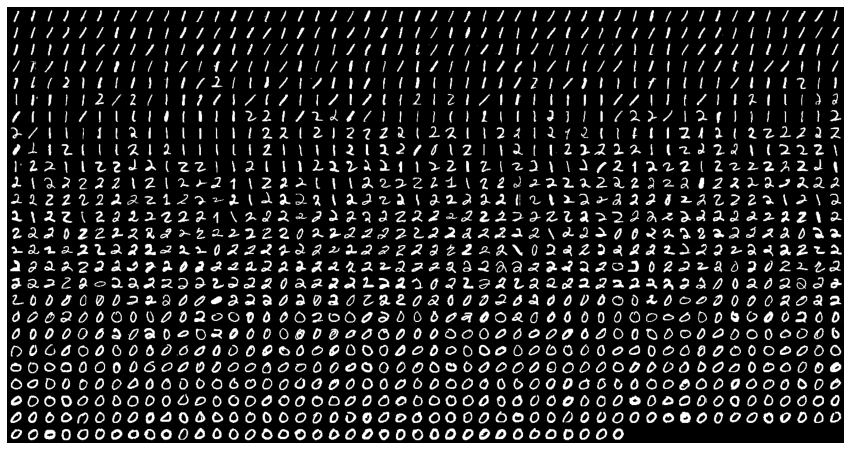

In [325]:
visualize_grid(make_grid(targets, nrow=50))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


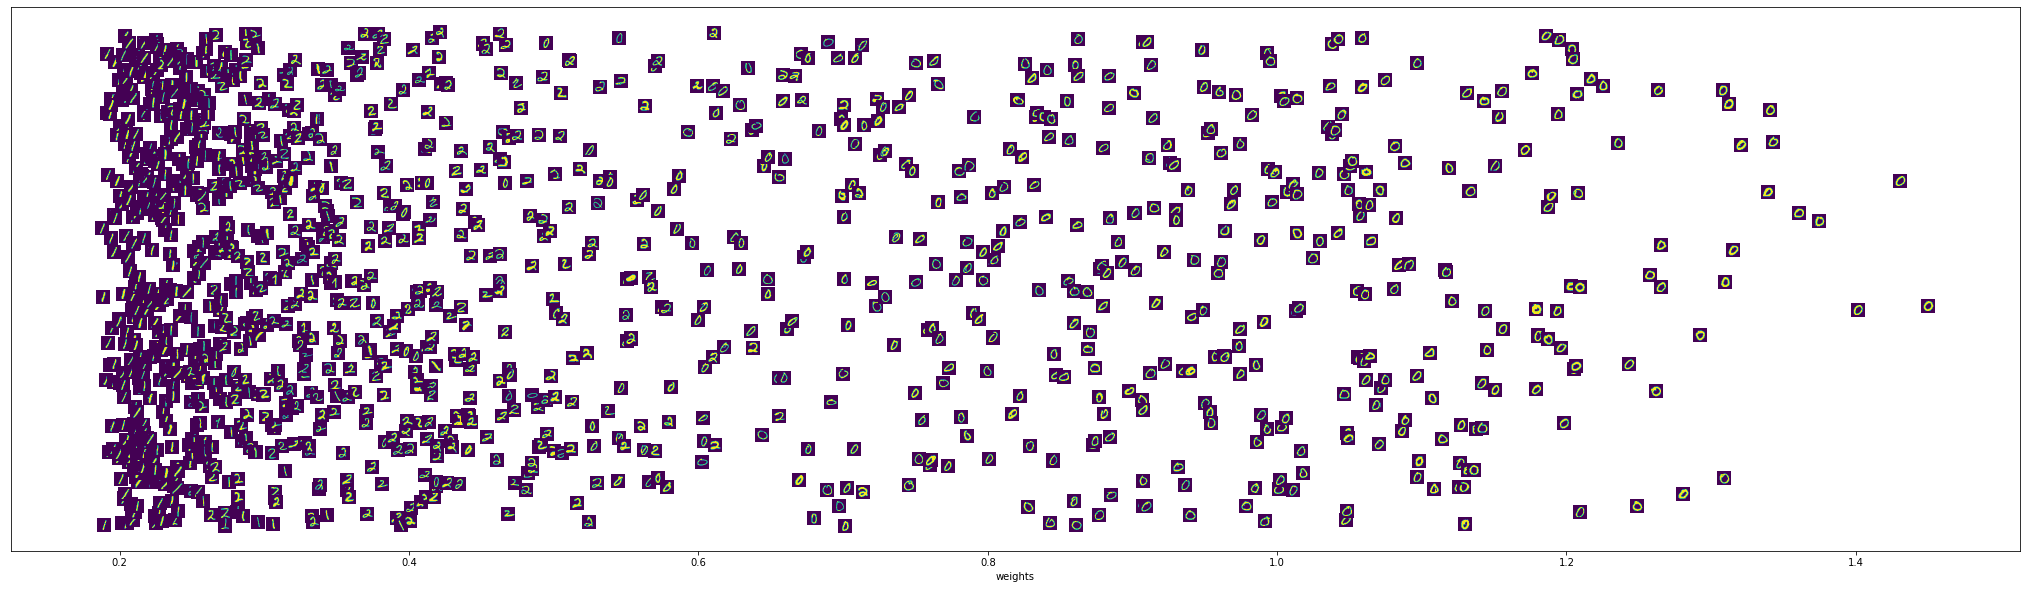

In [326]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# pixel_cols = df_subset.columns.str.startswith('pixel')
img_w, img_h = 28,28
zoom = 0.5

fig, ax = plt.subplots(figsize=(36,10))
for i, row in enumerate(targets):
    image = row.squeeze(0).cpu() #row[pixel_cols].values.astype(float).reshape((img_w, img_h))
    im = OffsetImage(image, zoom=zoom)
    rand_int = np.random.rand(1)
    ab = AnnotationBbox(im, (sorted_weights[i], rand_int), xycoords='data', frameon=False)
    ax.add_artist(ab)
    ax.update_datalim([(sorted_weights[i], rand_int)])
    ax.autoscale()
ax.set_xlabel('weights')
ax.get_yaxis().set_visible(False)

In [327]:
# import matplotlib.animation as animation
# from IPython.display import HTML

# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
# ims = []
# for i in range(len(targets)):
#     im1=ax.imshow(targets[i].squeeze(-1).squeeze(), cmap='gray',animated=True)
#     ims.append([im1])
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
# HTML(ani.to_jshtml())

In [328]:
# writergif = animation.PillowWriter(fps=30)

# ani.save('MNIST_weight_sorted4class.gif', writer=writergif)

In [329]:
from sklearn.decomposition import PCA

pca_z = PCA(n_components=2)
pca_zs = pca_z.fit_transform(mus.view(mus.shape[0], -1))

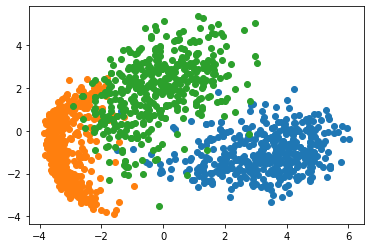

In [330]:
for c in range(10):
  idx = labels == c
  plt.scatter(pca_zs[idx, 0], pca_zs[idx, 1])

In [ ]:
targets = []

for weight in np.arange(-3, 5, 0.1):
  z_components = weight*pca_z.components_[0] + pca_z.mean_
  targets += [autoencoder.decoder(autoencoder.fc3(torch.Tensor(z_components).view(1,-1).cuda())).detach().cpu().squeeze(0).permute(1,2,0)]

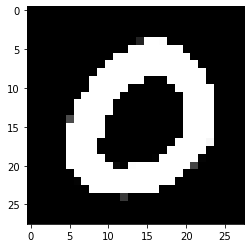

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ims = []
for i in range(len(targets)):
    im1=ax.imshow(targets[i].squeeze(-1), cmap='gray',animated=True)
    ims.append([im1])
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
writergif = animation.PillowWriter(fps=30)

ani.save('MNIST_latent_interpolation_PCA4classes.gif', writer=writergif)

KeyboardInterrupt: ignored